# Database examples

## Premise

Let's assume we want to upload a newly created isotherm in the internal
database. This isotherm is measured on the novel adsorbent *Carbon X1*, with
nitrogen at 77 K.

## Imports

First we need to do the required imports

In [1]:
import pygaps
import pygaps.parsing as pgp

## Upload

We happen to have the isotherm conveniently stored as a json file, so we load it
into memory and inspect it.

Material: Carbon X1
Adsorbate: nitrogen
Temperature: 77.355K
Units: 
	Uptake in: mmol/g
	Pressure in: bar
Other properties: 
	material_batch: X1
	iso_type: physisorption
	user: PI
	instrument: homemade1
	activation_temperature: 150.0
	lab: local
	treatment: acid activated



<AxesSubplot:xlabel='Pressure [$bar$]', ylabel='Loading [$mmol\\/g^{-1}$]'>

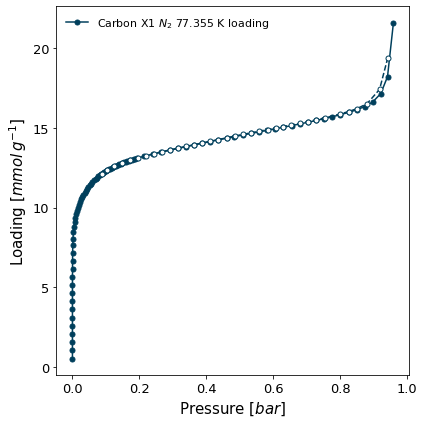

In [2]:
from pathlib import Path

json_path = Path.cwd() / 'data' / 'carbon_x1_n2.json'
with open(json_path) as text_file:
    isotherm = pgp.isotherm_from_json(text_file.read())

isotherm.print_info()

Now we can do the database upload.

In [3]:
isotherm.to_db()

Material uploaded: 'Carbon X1'
Isotherm uploaded: '29c44c6f12c0f4735b6de977bdcef5c5'


The output points out that two things happened:

- The isotherm material was first uploaded, using the `material.name` as a database ID.
- Then the isotherm itself was uploaded, using its `isotherm.iso_id` as the unique ID.

The adsorbate (`nitrogen`) is already in the database, so it does need to be stored.

Now if we try to run the upload again we get an error.

In [4]:
try:
    isotherm.to_db()
except Exception as e: 
    print(e)

Error inserting isotherm "29c44c6f12c0f4735b6de977bdcef5c5" base properties. Ensure material "Carbon X1", and adsorbate "nitrogen" exist in the database. Original error:
 UNIQUE constraint failed: isotherms.id


There was a `FOREIGN KEY` error: this isotherm is already in the database!

To retrieve the newly uploaded isotherm we can use the `isotherms_from_db()`
function. By default, it gets all existing isotherms, although it can be
configured to only return those matching a filter.

In [5]:
# Getting all isotherms: 1 found
isos = pgp.isotherms_from_db()
# Filtering isotherms with an adsorbate: 0 found
isos = pgp.isotherms_from_db(criteria={'adsorbate' : 'neon'})
# Filtering isotherms on a material: 1 found
isos = pgp.isotherms_from_db(criteria={'material' : 'Carbon X1'})

# Check if the isotherm is the same
print(isotherm == isos[0])

Selected 1 isotherms
Selected 0 isotherms
Selected 1 isotherms
True


<div class="alert alert-info">
Any kind of isotherm can be stored, including `ModelIsotherms` and `BaseIsotherms`.
</div>

If we want to remove the isotherm from the database, we can just use a delete function:

In [6]:
# This will remove the isotherm from the internal database
pgp.isotherm_delete_db(isotherm)

Isotherm deleted: '29c44c6f12c0f4735b6de977bdcef5c5'


<div class="alert alert-warning">
The corresponding isotherm `Material` and `Adsorbate` have not been deleted, just the `Isotherm`!
</div>

## Uploading Materials and Adsorbates

Besides `Isotherms`, individually created `Materials` and `Adsorbates` can
similarly be stored. If we attempt to create and upload a material which has
some more metadata about the *Carbon X1* sample we used previously.

In [7]:
novel_material = pygaps.Material(
    name='Carbon X1',
    contact='PI',
    source='local',
    treatment='etched',
)
try:
    pgp.material_to_db(novel_material)
except Exception as e:
    print(e)

UNIQUE constraint failed: materials.name


We get a foreign key error, since the material.name is still in the database from the initial isotherm upload!

Instead, we overwrite it, using a function parameter:

In [8]:
mats = pgp.materials_from_db()
print(mats[0])

Selected 1 materials
Carbon X1


In [9]:
pgp.material_to_db(novel_material, overwrite=True)

Material properties type uploaded 'contact'
Material properties type uploaded 'source'
Material properties type uploaded 'treatment'
Material uploaded: 'Carbon X1'


Several things happened behind the scenes, including an upload of the new
metadata types. Now the material has been updated. We can check this easily.

In [10]:
mats = pgp.materials_from_db()
print(mats[0] == novel_material)

# The material was also cached internally
print(novel_material in pygaps.MATERIAL_LIST)

Selected 1 materials
True
True


We can also delete this material.

In [11]:
pgp.material_delete_db(novel_material)

Material deleted: 'Carbon X1'


The same is true for `Adsorbates` by using the `adsorbate_to_db`/`adsorbates_from_db`/`adsorbate_delete_db` functions.

## Using a separate database

Up until now, we have been using the default database which comes with pyGAPS.
This may not be ideal for long term isotherm storage or making changes, as every
new pyGAPS version will replace the default database.

To see the location of the default database:

In [12]:
pygaps.DATABASE

WindowsPath('c:/users/pauli/git/pygaps/src/pygaps/data/default.db')

However you can easily create your own, then use it instead. To do this pyGAPS provides an utility function.

In [13]:
from pygaps.utilities.sqlite_db_creator import db_create

db_create("./own_database.db")

Experiment type uploaded 'isotherm'
Experiment type uploaded 'pointisotherm'
Experiment type uploaded 'modelisotherm'


This new database is identical to the default pyGAPS database, and includes all
adsorbate data. To use it for any storage, one can pass its path to the database
interaction functions.

In [14]:
pgp.material_to_db(novel_material, db_path="./own_database.db")
pgp.isotherm_to_db(isotherm, db_path="./own_database.db")

Material properties type uploaded 'contact'
Material properties type uploaded 'source'
Material properties type uploaded 'treatment'
Material uploaded: 'Carbon X1'
Isotherm uploaded: '29c44c6f12c0f4735b6de977bdcef5c5'
